In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import cross_validation
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

In [2]:
#reading in the data where my target variable resides
spend_df= pd.read_csv('Medicare Hospital Spending per Patient - Hospital.csv')
#creating my main dataset which I will call data
data =spend_df.loc[:,['Provider ID','Hospital Name','Score']]
data['Score']=data['Score'].replace("Not Available",np.nan)
data['Score']= pd.to_numeric(data['Score'], errors='coerce')
data = data.dropna(axis=0, how="any")


#### Reading in my dependent variable dataset

In [3]:
general= pd.read_csv('Hospital General Information.csv')
general.head()


,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Hospital Type,Hospital Ownership,...,Readmission national comparison,Readmission national comparison footnote,Patient experience national comparison,Patient experience national comparison footnote,Effectiveness of care national comparison,Effectiveness of care national comparison footnote,Timeliness of care national comparison,Timeliness of care national comparison footnote,Efficient use of medical imaging national comparison,Efficient use of medical imaging national comparison footnote
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Acute Care Hospitals,Government - Hospital District or Authority,...,Below the national average,NaN,Below the national average,NaN,Same as the national average,NaN,Same as the national average,NaN,Same as the national average,NaN
1,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,Acute Care Hospitals,Government - Hospital District or Authority,...,Above the national average,NaN,Same as the national average,NaN,Same as the national average,NaN,Above the national average,NaN,Below the national average,NaN
2,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,LAUDERDALE,2567688400,Acute Care Hospitals,Government - Hospital District or Authority,...,Below the national average,NaN,Below the national average,NaN,Same as the national average,NaN,Above the national average,NaN,Below the national average,NaN
3,10007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,3344933541,Acute Care Hospitals,Voluntary non-profit - Private,...,Below the national average,NaN,Same as the national average,NaN,Below the national average,NaN,Above the national average,NaN,Not Available,Results are not available for this reporting p...
4,10008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,3343353374,Acute Care Hospitals,Proprietary,...,Above the national average,NaN,Not Available,There are too few measures or measure groups r...,Same as the national average,NaN,Above the national average,NaN,Not Available,Results are not available for this reporting p...


In [4]:
#creating a dummy variable for whether the hospital is for-profit or not-for-profit 
# 0 = Not-For-Profit ; 1= For-Profit
general["Proprietary"]= 0
general["Proprietary"].loc[(general['Hospital Ownership'] == "Proprietary")] =1
print general["Proprietary"].value_counts()



0    4006
1     800
Name: Proprietary, dtype: int64


C:\Users\anirudha_nahar\AppData\Local\Continuum\anaconda2\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Creating dummy variables representing the hospital performance in 4 different quality areas compared to the national average. For each of these quality areas the hospital could be below the national average, at the national average, or above the national average.

In [5]:
general["HCAHPS_Below_Avg"]= 0 
general["HCAHPS_Below_Avg"].loc[(general['Patient experience national comparison'] == "Below the national average")] =1
general["HCAHPS_Below_Avg"].value_counts()

0    3686
1    1120
Name: HCAHPS_Below_Avg, dtype: int64

In [6]:
general["Readmission_Below_avg"] = 0
general["Readmission_Below_avg"].loc[(general["Readmission national comparison"] == "Below the national average")] =1
general["Readmission_Below_avg"].value_counts()

0    3428
1    1378
Name: Readmission_Below_avg, dtype: int64

In [7]:
general["Safety_Below_avg"] = 0
general["Safety_Below_avg"].loc[(general["Safety of care national comparison"] == "Below the national average")] =1
general["Safety_Below_avg"].value_counts()

0    3894
1     912
Name: Safety_Below_avg, dtype: int64

In [8]:
general["Timeliness_Below_avg"] = 0
general["Timeliness_Below_avg"].loc[(general["Timeliness of care national comparison"] == "Below the national average")] =1
general["Timeliness_Below_avg"].value_counts()

0    3810
1     996
Name: Timeliness_Below_avg, dtype: int64

In [9]:
general= general.loc[:,["Provider ID","Proprietary","HCAHPS_Below_Avg","Readmission_Below_avg","Safety_Below_avg","Timeliness_Below_avg"]]
general.head()

,Provider ID,Proprietary,HCAHPS_Below_Avg,Readmission_Below_avg,Safety_Below_avg,Timeliness_Below_avg
0,10001,0,1,1,0,0
1,10005,0,0,0,0,0
2,10006,0,1,1,0,0
3,10007,0,0,1,0,0
4,10008,1,0,0,0,0


In [10]:
data1= data.merge(general,on='Provider ID',how= 'left')
data1= data1.dropna(axis=0,how='any')
data1.tail()


,Provider ID,Hospital Name,Score,Proprietary,HCAHPS_Below_Avg,Readmission_Below_avg,Safety_Below_avg,Timeliness_Below_avg
3147,670108,BAYLOR SCOTT & WHITE MEDICAL CENTER - MARBLE F...,1.05,0,0,0,0,0
3148,670110,FIRST TEXAS HOSPITAL CARRROLLTON LLC,1.02,1,0,0,0,0
3149,670112,CUMBERLAND SURGICAL HOSPITAL,1.13,1,0,0,0,0
3150,670114,WEIMAR MEDICAL CENTER,0.90,1,0,0,0,0
3151,430081,PHS INDIAN HOSPITAL AT PINE RIDGE,0.75,0,0,1,0,0


#### Some Exploratory Data Analysis 

(0.5, 1.5)

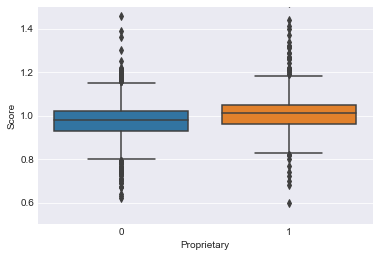

In [11]:
ax = sns.boxplot(x="Proprietary", y="Score", data=data1)
ax.set_ylim(0.5,1.5)


(0.5, 1.5)

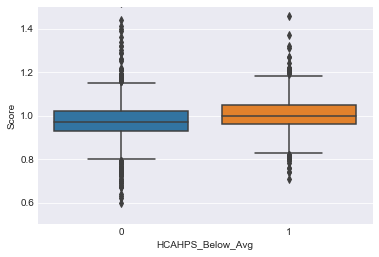

In [12]:
ax = sns.boxplot(x="HCAHPS_Below_Avg", y="Score", data=data1)
ax.set_ylim(0.5,1.5)


(0.5, 1.5)

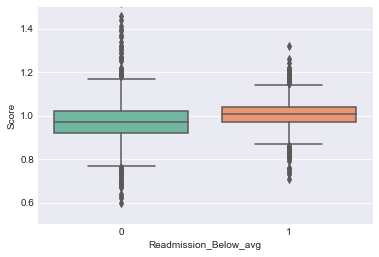

In [13]:
ax = sns.boxplot(x="Readmission_Below_avg", y="Score", data=data1, palette= "Set2")
ax.set_ylim(0.5,1.5)

(0.5, 1.5)

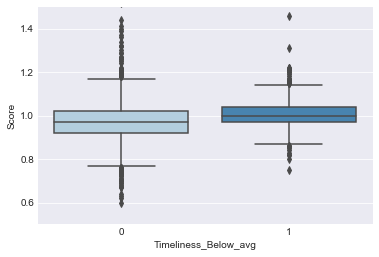

In [25]:
ax = sns.boxplot(x="Timeliness_Below_avg", y="Score", data=data1,  palette= "Blues")
ax.set_ylim(0.5,1.5)

(0.5, 1.5)

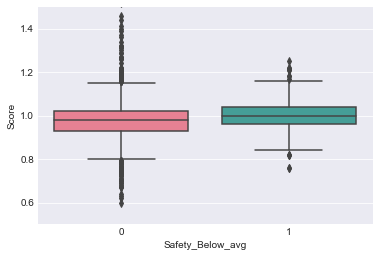

In [23]:
ax = sns.boxplot(x="Safety_Below_avg", y="Score", data=data1,  palette= "husl")
ax.set_ylim(0.5,1.5)

Looks like proprietary (For-Profit) hospitals generally have higher (worse) Medicare Spending per Benficiary Scores. Also Hospitals with Below Average Quality tend to have worse MSPB scores. 

AxesSubplot(0.125,0.125;0.62x0.755)


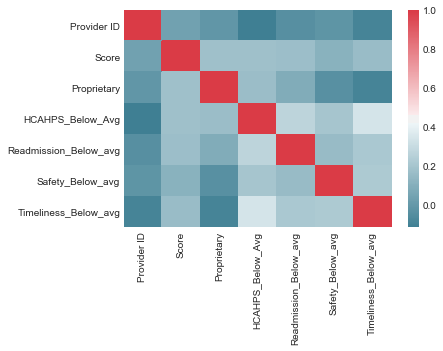

In [15]:
#checking for multicoliniarity 
cmap = sns.diverging_palette(220, 10, as_cmap=True)

correlations = data1.corr()
print sns.heatmap(correlations, cmap=cmap)

Looks like none of the variables are very correlated to each other so we should be good to go with the regression

In [16]:
y= pd.DataFrame(data1["Score"])
X= pd.DataFrame(data1.loc[:,["Proprietary","HCAHPS_Below_Avg","Readmission_Below_avg","Safety_Below_avg","Timeliness_Below_avg"]])
#X= pd.DataFrame(data1.loc[:,["HCAHPS Answer Percent"]])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
pred = regr.predict(X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, pred))



('Coefficients: \n', array([[ 0.04116489,  0.01342571,  0.01871739,  0.01258152,  0.02163327]]))
Mean squared error: 0.01
Variance score: 0.06


In [17]:
kf = cross_validation.KFold(len(X), n_folds=5, shuffle=True)

In [18]:
from sklearn import metrics
mse_values = []
scores = []
n= 0
print "~~~~ CROSS VALIDATION each fold ~~~~"
for train_index, test_index in kf:
    lm = linear_model.LinearRegression().fit(X.iloc[train_index], y.iloc[train_index])
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lm.predict(X.iloc[test_index])))
    scores.append(lm.score(X, y))
    n+=1
    print 'Model', n
    print 'MSE:', mse_values[n-1]
    print 'R2:', scores[n-1]


print "~~~~ SUMMARY OF CROSS VALIDATION ~~~~"
print 'Mean of MSE for all folds:', np.mean(mse_values)
print 'Mean of R2 for all folds:', np.mean(scores)

~~~~ CROSS VALIDATION each fold ~~~~
Model 1
MSE: 0.00548812576862
R2: 0.0853168208117
Model 2
MSE: 0.00720791892801
R2: 0.0855303025774
Model 3
MSE: 0.00769769427023
R2: 0.0855524746447
Model 4
MSE: 0.00595031452275
R2: 0.0855953360238
Model 5
MSE: 0.0108459963713
R2: 0.0856163806541
~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 0.00743800997217
Mean of R2 for all folds: 0.0855222629424


In [21]:
lm_stats = smf.ols(formula='y ~ Proprietary + HCAHPS_Below_Avg + Readmission_Below_avg+ Safety_Below_avg+Timeliness_Below_avg ', data=data1).fit()
#lm_stats = smf.ols(formula='y ~ X', data=data1).fit()

print lm_stats.summary()
print "~~~~~~~~"
print lm_stats.mse_total

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     59.13
Date:                Sun, 22 Apr 2018   Prob (F-statistic):           5.27e-59
Time:                        16:09:14   Log-Likelihood:                 3257.7
No. Observations:                3152   AIC:                            -6503.
Df Residuals:                    3146   BIC:                            -6467.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.95

The mean squared error and the R-Squared are both incredibly low. You would think that for a low R-Squared you would have a high error. This link offered inspiration for ways to tackle this problem: https://www.quora.com/How-do-we-reconcile-this-fact-%E2%80%9CThe-mean-squared-error-in-regression-is-close-to-zero-yet-the-R-squared-values-are-much-lower%E2%80%9D

In essence I realized that if the variance of your target/ independent variable is too little, then your regression starts to become useless and you can experience the case in which both R-Squared and Mean Squared Error are too low. 

In [ ]:
print "Variance of Dependent Variable: ", data1["Score"].var()
data1.describe()

In [ ]:
plot_score= pd.Series(data1["Score"],name= "MSBP Scores")
sns.distplot(data1["Score"])

The variance of our target variable is 0.008 which is incredibly low! Plotting a distribution of our dependent variable (Medicare SPending per Beneficiary Score) we can see that most fall close to 1.0. 